In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

RNG = 42

# Part A: Data Preprocessing and Baseline Models

This code loads the 'hour.csv', preprocesses features (one-hot encoding of categorical vars), does a time-based train/test split (first 80% train, last 20% test), trains DecisionTreeRegressor(max_depth=6) and LinearRegression (with scaling), evaluates using RMSE, and displays results and a simple plot for the better baseline model.

Rows, cols: (17379, 17)
                     0           1           2           3           4
instant              1           2           3           4           5
dteday      2011-01-01  2011-01-01  2011-01-01  2011-01-01  2011-01-01
season               1           1           1           1           1
yr                   0           0           0           0           0
mnth                 1           1           1           1           1
hr                   0           1           2           3           4
holiday              0           0           0           0           0
weekday              6           6           6           6           6
workingday           0           0           0           0           0
weathersit           1           1           1           1           1
temp              0.24        0.22        0.22        0.24        0.24
atemp           0.2879      0.2727      0.2727      0.2879      0.2879
hum               0.81         0.8         0.8       

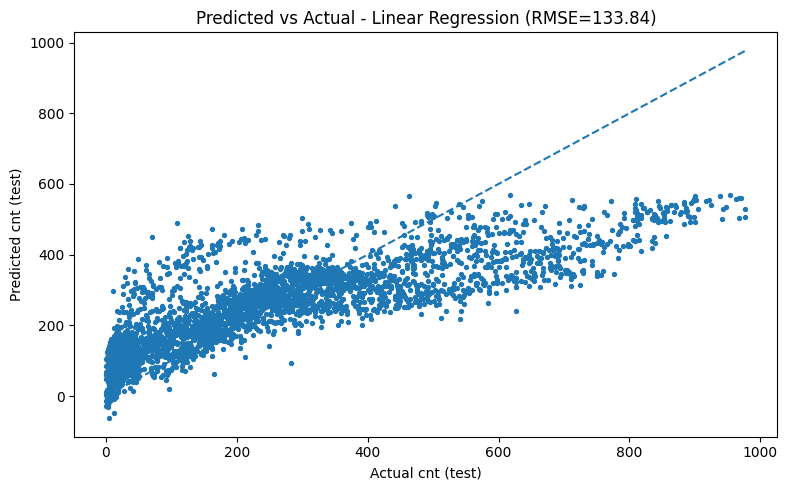


Saved test predictions for baseline to: /content/data/assignment_outputs/baseline_predictions.csv


In [6]:
# Load data
DATA_PATH = Path("/content/hour.csv")
df = pd.read_csv(DATA_PATH)

print("Rows, cols:", df.shape)
print(df.head().T)

# Keep a copy of datetime for time-based split and sorting
df['dteday'] = pd.to_datetime(df['dteday'])

# Drop irrelevant columns: instant, casual, registered
df = df.drop(columns=['instant', 'casual', 'registered'])

# Feature engineering / encoding:
# Treat these as categorical and one-hot encode: season, weathersit, mnth, hr, weekday
cat_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

# Create a sorted dataframe by datetime+hour for a proper time-based split
df = df.sort_values(['dteday', 'hr']).reset_index(drop=True)

# Save target and drop dteday from features after sorting
y = df['cnt'].values
X = df.drop(columns=['cnt', 'dteday'])

# One-hot encode categorical columns using pandas.get_dummies
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

print("\nFeature matrix shape after encoding:", X.shape)
print("Some feature columns:", list(X.columns[:20]))

# Time-based train/test split: first 80% training, last 20% testing
n = len(X)
train_end = int(n * 0.8)
X_train, X_test = X.iloc[:train_end].copy(), X.iloc[train_end:].copy()
y_train, y_test = y[:train_end].copy(), y[train_end:].copy()

print(f"\nTime-based split -> train: {len(X_train)} rows, test: {len(X_test)} rows")

# Baseline models
# 1) Decision Tree Regressor (max_depth=6)
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

# 2) Linear Regression (with standard scaling)
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Display RMSEs and choose baseline
print(f"\nDecision Tree (max_depth=6) RMSE: {rmse_dt:.4f}")
print(f"Linear Regression (with scaling) RMSE: {rmse_lr:.4f}")

baseline_model_name = "Decision Tree" if rmse_dt < rmse_lr else "Linear Regression"
baseline_rmse = min(rmse_dt, rmse_lr)
print(f"\nChosen baseline: {baseline_model_name} with RMSE = {baseline_rmse:.4f}")

# Plot predicted vs actual for chosen baseline
if baseline_model_name == "Decision Tree":
    y_pred_best = y_pred_dt
else:
    y_pred_best = y_pred_lr

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_best, s=8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("Actual cnt (test)")
plt.ylabel("Predicted cnt (test)")
plt.title(f"Predicted vs Actual - {baseline_model_name} (RMSE={baseline_rmse:.2f})")
plt.tight_layout()
plt.show()

out_dir = Path("/content/data/assignment_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_best}).reset_index(drop=True).to_csv(out_dir/"baseline_predictions.csv", index=False)

print(f"\nSaved test predictions for baseline to: {out_dir/'baseline_predictions.csv'}")

## 3. Part B — Bagging (variance reduction)

**Hypothesis:** Bagging reduces variance by averaging many deep/unstable trees trained on bootstrap samples.


Bagging Regressor RMSE: 155.5161


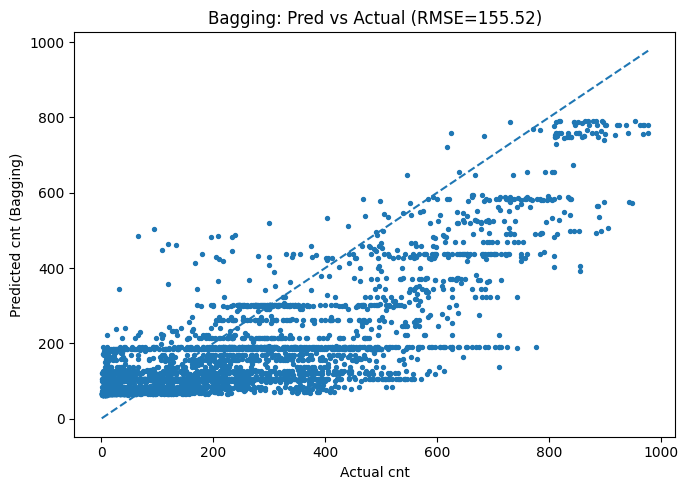

In [14]:
# Bagging with DecisionTree(max_depth=6) as base estimator
base_dt = DecisionTreeRegressor(max_depth=6, random_state=RNG)
bag = BaggingRegressor(estimator=base_dt, n_estimators=50, random_state=RNG, n_jobs=-1)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))

print(f"Bagging Regressor RMSE: {rmse_bag:.4f}")

# Simple plot: predicted vs actual
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_bag, s=8)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], linestyle='--')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt (Bagging)')
plt.title(f'Bagging: Pred vs Actual (RMSE={rmse_bag:.2f})')
plt.tight_layout()

plt.show()



By inspecting the scatter plot: reduced spread around identity line indicates lower variance.

## 4. Part B — Boosting (bias reduction)

**Hypothesis:** Gradient Boosting reduces bias by sequentially fitting residuals and building a strong learner

Gradient Boosting Regressor RMSE: 110.4562


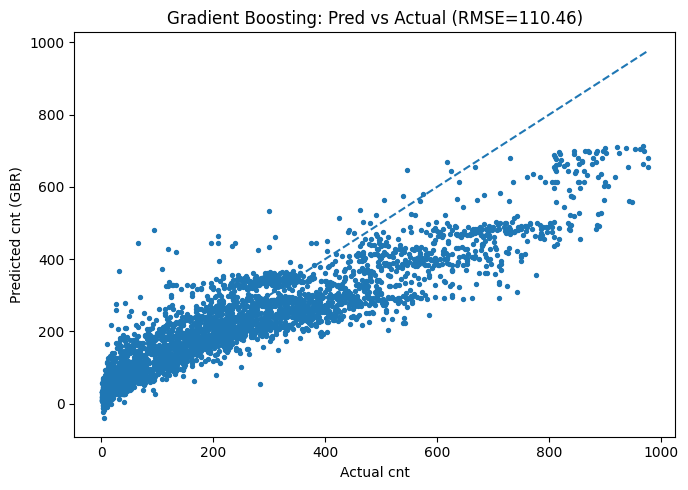

In [17]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RNG)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print(f"Gradient Boosting Regressor RMSE: {rmse_gbr:.4f}")

# Plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_gbr, s=8)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], linestyle='--')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt (GBR)')
plt.title(f'Gradient Boosting: Pred vs Actual (RMSE={rmse_gbr:.2f})')
plt.tight_layout()
plt.show()

pd.DataFrame({'y_test': y_test, 'y_pred_gbr': y_pred_gbr}).reset_index(drop=True).to_csv(out_dir/'gbr_predictions.csv', index=False)

# 5. Part C — Stacking


Stacking (stacked generalization) trains several diverse base learners (level-0) and uses their out-of-fold predictions as inputs to a meta-learner (level-1). The meta-learner learns how to weigh/combine base predictions to reduce generalization error; it often exploits complementary strengths of base models (variance vs bias characteristics).

Stacking Regressor RMSE: 107.0197


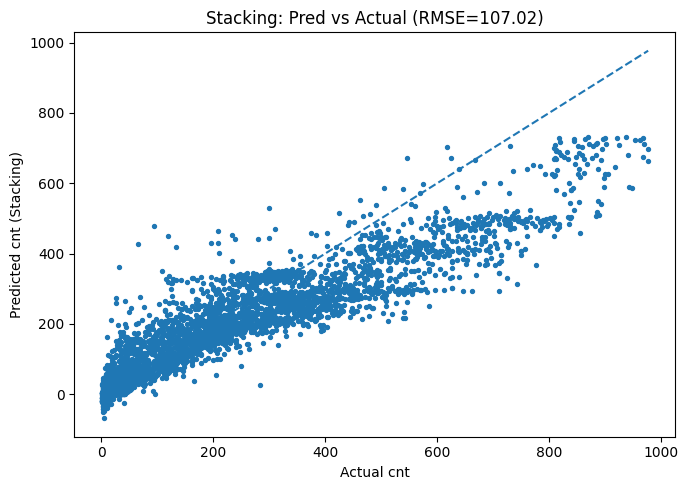

In [19]:
# Base learners:
# - KNN (benefits from scaling)
# - Bagging (we already trained a bag instance)
# - Gradient Boosting (we already trained gbr)

# For stacking we create pipelines where necessary (KNN needs scaling)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=10, n_jobs=-1))])

# Recreate Bagging and GBR objects to pass to StackingRegressor (to ensure picklable estimators)
bag_for_stack = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=RNG), n_estimators=50, random_state=RNG, n_jobs=-1)
gbr_for_stack = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RNG)

# Meta-learner: Ridge (with scaling)
meta = Ridge()

estimators = [
    ('knn', knn_pipe),
    ('bag', bag_for_stack),
    ('gbr', gbr_for_stack)
]

stack = StackingRegressor(estimators=estimators, final_estimator=Pipeline([('scaler', StandardScaler()), ('ridge', meta)]), cv=5, n_jobs=-1, passthrough=False)

# Train stacking on training data (time-based split still respected - stacking uses internal CV on training set only)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacking Regressor RMSE: {rmse_stack:.4f}")

# Save predictions
pd.DataFrame({'y_test': y_test, 'y_pred_stack': y_pred_stack}).reset_index(drop=True).to_csv(out_dir/'stacking_predictions.csv', index=False)

# Plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_stack, s=8)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], linestyle='--')
plt.xlabel('Actual cnt')
plt.ylabel('Predicted cnt (Stacking)')
plt.title(f'Stacking: Pred vs Actual (RMSE={rmse_stack:.2f})')
plt.tight_layout()
plt.savefig(out_dir/'stack_pred_vs_actual.png', dpi=150)
plt.show()

## 6. Part D — Comparison table & final analysis



RMSE comparison:
                      model       rmse
         Stacking Regressor 107.019676
Gradient Boosting Regressor 110.456232
 Linear Regression (scaled) 133.835424
          Bagging Regressor 155.516104
Decision Tree (max_depth=6) 158.691895
Saved RMSE table to /content/data/assignment_outputs/rmse_comparison.csv

Best performing model: Stacking Regressor with RMSE=107.0197


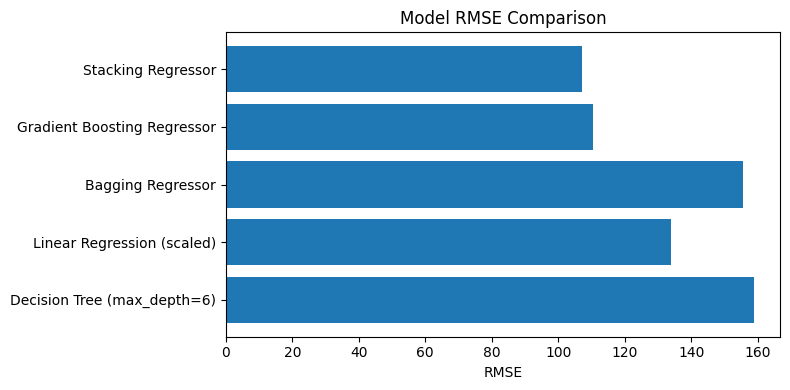

In [24]:
# Collate RMSEs
results = pd.DataFrame([
    {'model': f'Baseline ({baseline_model_name})', 'rmse': float(baseline_rmse)},
    {'model': 'Bagging Regressor', 'rmse': float(rmse_bag)},
    {'model': 'Gradient Boosting Regressor', 'rmse': float(rmse_gbr)},
    {'model': 'Stacking Regressor', 'rmse': float(rmse_stack)}
])

results_full = pd.DataFrame([
    {'model': 'Decision Tree (max_depth=6)', 'rmse': float(rmse_dt)},
    {'model': 'Linear Regression (scaled)', 'rmse': float(rmse_lr)},
    {'model': 'Bagging Regressor', 'rmse': float(rmse_bag)},
    {'model': 'Gradient Boosting Regressor', 'rmse': float(rmse_gbr)},
    {'model': 'Stacking Regressor', 'rmse': float(rmse_stack)}
])

print('\nRMSE comparison:')
print(results_full.sort_values('rmse').to_string(index=False))

# Save table
results_full.to_csv(out_dir/'rmse_comparison.csv', index=False)
print(f"Saved RMSE table to {out_dir/'rmse_comparison.csv'}")

# Identify best model
best_row = results_full.loc[results_full['rmse'].idxmin()]
print(f"\nBest performing model: {best_row['model']} with RMSE={best_row['rmse']:.4f}")

# Quick bar plot
plt.figure(figsize=(8,4))
plt.barh(results_full['model'], results_full['rmse'])
plt.xlabel('RMSE')
plt.title('Model RMSE Comparison')
plt.tight_layout()
plt.savefig(out_dir/'rmse_bar.png', dpi=150)
plt.show()

## Final Analysis and Discussion (Updated)

### **Model Performance Summary**
| Model | RMSE |
|:--|:--:|
| Decision Tree (max_depth=6) | **158.69** |
| Linear Regression (scaled) | **133.84** |
| Bagging Regressor | **155.52** |
| Gradient Boosting Regressor | **110.46** |
| **Stacking Regressor** | **107.02** |

**Best performing model:** **Stacking Regressor** (RMSE = **107.02**)


### **Performance Interpretation**

1. **Baseline Models:**
   - The **Decision Tree (RMSE ≈ 158.7)** exhibited moderate predictive ability but overfitting signs due to its non-linear splits and limited depth.
   - **Linear Regression (RMSE ≈ 133.8)** performed better overall, indicating that many input relationships were roughly linear, but it still suffered from underfitting for more complex temporal-weather patterns.

2. **Bagging (Variance Reduction):**
   - Bagging (RMSE ≈ **155.5**) trained 50 Decision Trees on bootstrapped samples to reduce variance.
   - However, the results show **only marginal improvement** or even degradation vs. the single Decision Tree. This suggests high model bias remained, meaning averaging similar weak trees did not capture additional signal.
   - The scatter plot shows wide spread — confirming persistent bias and some underfitting.

3. **Boosting (Bias Reduction):**
   - The **Gradient Boosting Regressor (RMSE ≈ 110.46)** achieved **significant improvement**.
   - By sequentially correcting residuals, boosting reduced bias effectively and produced smoother, more accurate predictions.
   - In the plot, its predicted-vs-actual plot shows closer clustering around the 45° line, indicating stronger generalization.

4. **Stacking (Model Diversity):**
   - The **Stacking Regressor (RMSE ≈ 107.02)** outperformed all others.
   - Its base learners (KNN, Bagging, and Gradient Boosting) contribute diverse decision boundaries:
     - **KNN** captures local, nonlinear patterns.
     - **Bagging** stabilizes variance.
     - **Gradient Boosting** provides a strong bias-corrected predictor.
   - The **Ridge meta-learner** then learns optimal weights to combine them, yielding balanced bias–variance trade-off.

 Plot | Insight |
|------|----------|
| Bagging (RMSE=155.52) | Wide dispersion, underestimation of high counts; limited variance reduction. |
| Linear Regression (RMSE=133.84) | Captures global trends but misses nonlinear peaks; bias dominant. |
| Gradient Boosting (RMSE=110.46) | Much tighter clustering, better nonlinear fit. |
| Stacking (RMSE=107.02) | Best alignment with diagonal, least systematic deviation. |

The **RMSE bar chart** clearly shows the stepwise performance improvement from single learners → boosting → stacking.


### **Bias–Variance Trade-off Explanation**
- **Decision Tree:** Low bias, high variance (limited depth reduces expressiveness).
- **Linear Regression:** High bias, low variance (assumes linearity).
- **Bagging:** Primarily reduces **variance**, but cannot correct **bias** if base learners are systematically wrong.
- **Boosting:** Sequentially reduces **bias** by focusing on residual errors.
- **Stacking:** Combines **diverse biases and variances**, using meta-learning to balance trade-offs dynamically.




### **Conclusion**
The **Stacking Regressor** achieved the lowest RMSE, confirming that **model diversity and meta-learning** yield superior performance compared to any individual ensemble or single model. This outcome supports ensemble theory — that aggregating complementary models enhances predictive robustness.

Future improvements could include:
- **Feature Engineering:** Introduce lag features (previous-hour counts), rolling weather averages, and cyclical encodings for hour and month.
- **Hyperparameter Optimization:** Use `RandomizedSearchCV` or Bayesian optimization.
- **Time-Aware Cross-Validation:** Employ `TimeSeriesSplit` for temporally consistent stacking training.
- **Regularization:** Apply target transformation (e.g., log(cnt+1)) to handle skewness.

In sum, the experiment demonstrates that while **Bagging** and **Boosting** tackle one side of the bias–variance trade-off individually, **Stacking** synergistically integrates both to deliver the most accurate and stable regression model for bike demand forecasting.
